In [1]:
import pandas as pd
import numpy as np
from math import isnan
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from itertools import chain
from src.swap_utils import get_pool_value_by_coin

from src.data_extractors import get_pools, get_prices, get_price_enriched

#### Get Bostrom and Osmosis Pools Data

In [2]:
pools_df = get_pools(display_data=True)
pools_df = pools_df[(pools_df.id != 1) | (pools_df.network != 'osmosis')]

Bostrom Pools


id,type_id,reserve_coin_denoms,reserve_account_address,pool_coin_denom,balances,swap_fee,network
1,1,"[boot, hydrogen]",bostrom1wrtkzr96362ty7ad0qrwhkpx743xcjrtv7j2cw,pool70D7610CBA8E94B27BAD7806EBD826F5626C486BBF5...,"[{'denom': 'boot', 'amount': '1168669761963'}, ...",0.003,bostrom
2,1,"[boot, milliampere]",bostrom1y7au5el59mf8mlak53gfvmr75gr2m2jz6lra0s,pool27BBCA67F42ED27DFFB6A450966C7EA206ADAA42BA0...,"[{'denom': 'boot', 'amount': '10617545537'}, {'...",0.003,bostrom
3,1,"[boot, tocyb]",bostrom1tkpsxklqu74eqsmezcwnc5hmfswrjgn9elcneq,pool5D83035BE0E7AB904379161D3C52FB4C1C392265AC1...,"[{'denom': 'boot', 'amount': '20716808546'}, {'...",0.003,bostrom
4,1,"[hydrogen, tocyb]",bostrom1kqkwg2eq9fc5r8f0n66fj6ekc5h3kkmqhthkqx,poolB02CE42B202A71419D2F9EB4996B36C52F1B5B60DAF...,"[{'denom': 'hydrogen', 'amount': '10150623639'}...",0.003,bostrom
5,1,"[hydrogen, milliampere]",bostrom10xu73c3nkcdcf6j6u4j2kzq0cjftfj2nv7xz9y,pool79B9E8E233B61B84EA5AE564AB080FC492B4C953A9D...,"[{'denom': 'hydrogen', 'amount': '668273800487'...",0.003,bostrom
6,1,"[hydrogen, millivolt]",bostrom1u3u628ue3c5hn7ya4x4cjlk5t2d0unnarrq34k,poolE479A51F998E2979F89DA9AB897ED45A9AFE4E7DE32...,"[{'denom': 'hydrogen', 'amount': '262306941730'...",0.003,bostrom
7,1,"[hydrogen, uosmo in bostrom]",bostrom1np5jg5xq8x7axptrgad8dxd8spg8tavjh5vnaz,pool98692450C039BDD30563475A7699A7805075F592A36...,"[{'denom': 'hydrogen', 'amount': '1073298607935...",0.003,bostrom
8,1,"[hydrogen, deprecated uatom in bostrom]",bostrom1mgv368468aq8fsk2kynh0lpcsgtwa53zzlnhp0,poolDA191D1EBA3F4074C2CAB12777FC388216EED222F57...,[],0.003,bostrom
9,1,"[uosmo in bostrom, deprecated uatom in bostrom]",bostrom1tyx5u9mgwxzzj6rstsjxmfswpft75s0euh5ppu,pool590D4E176871842968705C246DA60E0A57EA41F9257...,[],0.003,bostrom
10,1,"[milliampere, millivolt]",bostrom1jphne3xq7335qvvepkupwcda8yyfp79ggfx7hy,pool906F3CC4C0F4634031990DB81761BD390890F8A8A80...,"[{'denom': 'milliampere', 'amount': '99824016'}...",0.003,bostrom


Osmosis Pools


@type,address,id,pool_params,future_pool_governor,total_shares,pool_assets,total_weight,pool_liquidity,scaling_factors,scaling_factor_controller,type_id,balances,denoms_count,swap_fee,exit_fee,reserve_coin_denoms,network,uosmo_balance,uatom_balance
/osmosis.gamm.v1beta1.Pool,osmo15jt5g7jn3m2wem6an2n9m982hr6v2madrhjyt3vxrn...,552,"{'swap_fee': '0.003000000000000000', 'exit_fee'...",24h,"{'denom': 'gamm/pool/552', 'amount': '100000000...",[{'token': {'denom': 'ibc/27394FB092D2ECCD56123...,1073742897741824,NaN,NaN,NaN,1,"[{'denom': 'uatom in osmosis', 'amount': '1', '...",2,0.003000,0.001,"[uatom in osmosis, ibc/9989AD6CCA39D1131523DB06...",osmosis,NaN,None
/osmosis.gamm.v1beta1.Pool,osmo1mw0ac6rwlp5r8wapwk3zs6g29h8fcscxqakdzw9emk...,1,"{'swap_fee': '0.002000000000000000', 'exit_fee'...",24h,"{'denom': 'gamm/pool/1', 'amount': '26148298045...",[{'token': {'denom': 'ibc/27394FB092D2ECCD56123...,1073741824000000,NaN,NaN,NaN,1,"[{'denom': 'uatom in osmosis', 'amount': '26197...",2,0.002000,0.000,"[uatom in osmosis, uosmo]",osmosis,3.697959e+13,None
/osmosis.gamm.v1beta1.Pool,osmo1avdp69rp58an6hysjh5n6g9w0wx73sytfxcg3qjynn...,673,"{'swap_fee': '0.002000000000000000', 'exit_fee'...",24h,"{'denom': 'gamm/pool/673', 'amount': '535793932...",[{'token': {'denom': 'ibc/27394FB092D2ECCD56123...,1073741824000000,NaN,NaN,NaN,1,"[{'denom': 'uatom in osmosis', 'amount': '1182'...",2,0.002000,0.000,"[uatom in osmosis, ibc/F292A17CF920E3462C816CBE...",osmosis,NaN,None
/osmosis.gamm.v1beta1.Pool,osmo13tc9ntd0rnxumtlczqefzg5nk2kf6z7agmgj898sd3...,669,"{'swap_fee': '0.002000000000000000', 'exit_fee'...",24h,"{'denom': 'gamm/pool/669', 'amount': '425331549...",[{'token': {'denom': 'ibc/6BDB4C8CCD45033F9604E...,1073741824000000,NaN,NaN,NaN,1,[{'denom': 'ibc/6BDB4C8CCD45033F9604E4B93ED3950...,2,0.002000,0.000,[ibc/6BDB4C8CCD45033F9604E4B93ED395008A753E01EE...,osmosis,3.800934e+08,None
/osmosis.gamm.v1beta1.Pool,osmo1937gh7cem2tn09r7c4uh7zgjvgjyxlffa677rv7zms...,668,"{'swap_fee': '0.003000000000000000', 'exit_fee'...",24h,"{'denom': 'gamm/pool/668', 'amount': '218226067...",[{'token': {'denom': 'ibc/27394FB092D2ECCD56123...,1073741824000000,NaN,NaN,NaN,1,"[{'denom': 'uatom in osmosis', 'amount': '2594'...",2,0.003000,0.000,"[uatom in osmosis, ibc/BE1BB42D4BE3C30D50B68D7C...",osmosis,NaN,None
/osmosis.gamm.v1beta1.Pool,osmo1kg2ga83a9g5rhv5xu2m24q8rnqjv5vr6257cc2ny5x...,667,"{'swap_fee': '0.003000000000000000', 'exit_fee'...",24h,"{'denom': 'gamm/pool/667', 'amount': '690570304...",[{'token': {'denom': 'ibc/27394FB092D2ECCD56123...,1073741824000000,NaN,NaN,NaN,1,"[{'denom': 'uatom in osmosis', 'amount': '38003...",2,0.003000,0.000,"[uatom in osmosis, ibc/41999DF04D9441DAC0DF5D82...",osmosis,NaN,None
/osmosis.gamm.v1beta1.Pool,osmo19a6nnvczjpnjzt3wgrf4h02yej62wpvnq9cayph7ec...,666,"{'swap_fee': '0.000000000000000000', 'exit_fee'...",24h,"{'denom': 'gamm/pool/666', 'amount': '450000000...",[{'token': {'denom': 'ibc/27394FB092D2ECCD56123...,1073741824000000,NaN,NaN,NaN,1,"[{'denom': 'uatom in osmosis', 'amount': '358',...",2,0.000000,0.000,"[uatom in osmosis, ibc/41999DF04D9441DAC0DF5D82...",osmosis,NaN,None
/osmosis.gamm.v1beta1.Pool,osmo15h02q7rzpwn0gahklnek29naae4peg3j4rd5e4hcc2...,665,"{'swap_fee': '0.003000000000000000', 'exit_fee'...",24h,"{'denom': 'gamm/pool/665', 'amount': '417187500...",[{'token': {'denom': 'ibc/27394FB092D2ECCD56123...,1073741824000000,NaN,NaN,NaN,1,"[{'denom': 'uatom in osmosis', 'amount': '210',...",2,0.003000,0.000,"[uatom in osmosis, ibc/41999DF04D9441DAC0DF5D82...",osmosis,NaN,None
/osmosis.gamm.v1beta1.Pool,osmo15t7afyxut7eugx0yn4quesujf5snv358g3ureyx46a...,664,"{'swap_fee': '0.003000000000000000', 'exit_fee'...",24h,"{'denom': 'gamm/pool/664', 'amount': '935189921...",[{'token': {'denom': 'ibc/27394FB092D2ECCD56123...,1073741824000000,NaN,NaN,NaN,1,"[{'denom': 'uatom in osmosis', 'amount': '69', ...",2,0.003000,0.000,"[uatom in osmosis, ibc/41999DF04D9441DAC0DF5D82...",osmosis,NaN,None
/osmosis.gamm.v1beta1.Pool,osmo1v38v9n

#### Calculate Prices

In [3]:
price_df = get_prices(pools_df=pools_df, display_data=True)

,ugraviton in bostrom,uosmo in bostrom,milliampere,udsm in bostrom,wei gravETH in bostrom,uatom in osmosis,boot in osmosis,ujuno in bostrom,pussy in bostrom,deprecated uatom in bostrom,uosmo,aevmos in bostrom,boot,liquidpussy in bostrom,hydrogen,millivolt,tocyb,uatom in bostrom
ugraviton in bostrom,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.649986,NaN,NaN,NaN
uosmo in bostrom,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0.004457,NaN,NaN,13.805705
milliampere,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000672,NaN,0.00021,9.425027,NaN,NaN
udsm in bostrom,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.135214,NaN,NaN,NaN
wei gravETH in bostrom,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2651356.198129,NaN,NaN,NaN
uatom in osmosis,NaN,NaN,NaN,NaN,NaN,1,0.001066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
boot in osmosis,NaN,NaN,NaN,NaN,NaN,932.085314,1,NaN,NaN,NaN,65.871654,NaN,1,NaN,NaN,NaN,NaN,NaN
ujuno in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.002852,NaN,NaN,NaN
pussy in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,3651.346088,NaN,1142.391985,NaN,NaN,NaN
deprecated uatom in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Prices without References to the Networks

In [4]:
price_enriched_df = get_price_enriched(price_df=price_df, display_data=True)

,ugraviton in bostrom,uosmo in bostrom,milliampere,udsm in bostrom,wei gravETH in bostrom,uatom in osmosis,boot in osmosis,ujuno in bostrom,pussy in bostrom,deprecated uatom in bostrom,uosmo,aevmos in bostrom,boot,liquidpussy in bostrom,hydrogen,millivolt,tocyb,uatom in bostrom
ugraviton in bostrom,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.649986,NaN,NaN,NaN
uosmo in bostrom,NaN,1,NaN,NaN,NaN,13.805705,0.01512,NaN,NaN,NaN,1,NaN,0.01512,NaN,0.004457,NaN,NaN,13.805705
milliampere,NaN,NaN,1,NaN,NaN,NaN,0.000672,NaN,NaN,NaN,NaN,NaN,0.000672,NaN,0.00021,9.425027,NaN,NaN
udsm in bostrom,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.135214,NaN,NaN,NaN
wei gravETH in bostrom,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2651356.198129,NaN,NaN,NaN
uatom in osmosis,NaN,0.072,NaN,NaN,NaN,1,0.001066,NaN,NaN,NaN,0.072,NaN,0.001066,NaN,0.000319,NaN,NaN,1
boot in osmosis,NaN,65.871654,1479.684141,NaN,NaN,932.085314,1,NaN,0.000272,NaN,65.871654,NaN,1,NaN,0.315069,13943.342569,0.757358,932.085314
ujuno in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.002852,NaN,NaN,NaN
pussy in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,3651.346088,NaN,1,NaN,NaN,NaN,3651.346088,NaN,1142.391985,NaN,NaN,NaN
deprecated uatom in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Get Pools Liquidity

network,id,reserve_coin_denoms,"liquidity, GH"
osmosis,596,"[uatom in osmosis, boot in osmosis]","2,040.5"
osmosis,597,"[boot in osmosis, uosmo]",780.7
bostrom,1,"[boot, hydrogen]","7,396.3"
bostrom,12,"[hydrogen, uatom in bostrom]","4,806.5"
bostrom,18,"[uosmo in bostrom, uatom in bostrom]","2,925.0"
bostrom,19,"[hydrogen, wei gravETH in bostrom]","2,303.0"
bostrom,7,"[hydrogen, uosmo in bostrom]","2,146.6"
bostrom,5,"[hydrogen, milliampere]","1,336.5"
bostrom,16,"[hydrogen, ujuno in bostrom]","1,087.2"
bostrom,10,"[milliampere, millivolt]",943.8


Total liquidity: 28,437 GH


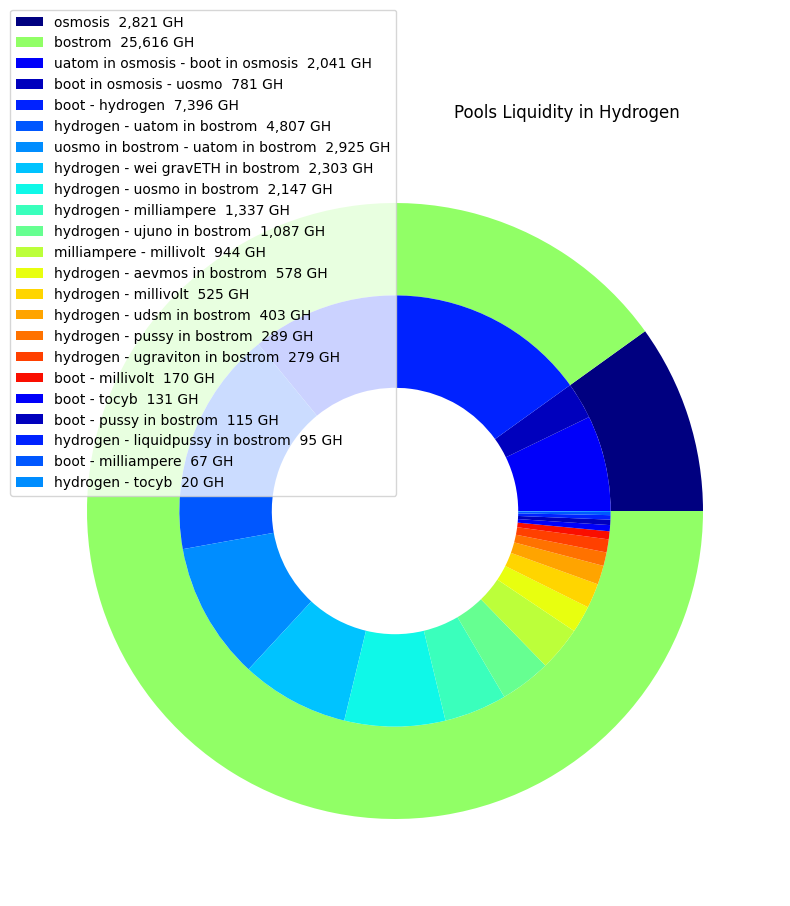

In [5]:
def get_pool_liquidity(balances: list, target_denom: str = 'hydrogen', main_liquidity_denom: str = 'hydrogen',
                       price_enriched_df: pd.DataFrame = price_enriched_df) -> float:
    if not balances:
        return 0
    denoms = [item['denom'] for item in balances]
    balances_dict = {item['denom']: int(item['amount']) for item in balances}
    if target_denom in denoms:
        return balances_dict[target_denom] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, denoms[1]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(
            price_df.loc[main_liquidity_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * \
               price_enriched_df.loc[main_liquidity_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(price_df.loc[main_liquidity_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * \
               price_enriched_df.loc[main_liquidity_denom, denoms[1]] * 2
    return 0


pools_df['liquidity, GH'] = pools_df['balances'].map(get_pool_liquidity) / 1e9
display(HTML(
    pools_df[(pools_df.network != 'osmosis') | (pools_df.id != 1)][
        ['network', 'id', 'reserve_coin_denoms', 'liquidity, GH']]
    .sort_values(['network', 'liquidity, GH'], ascending=False)
    .to_html(index=False, notebook=True, show_dimensions=False, float_format='{0:7,.1f}'.format)
    .replace('text-align: left;', 'text-align: right')
    .replace('<tr>', '<tr align="right">')))

print(
    f"Total liquidity: {round(sum(pools_df[(pools_df.network != 'osmosis') | (pools_df.id != 1)]['liquidity, GH'])):>,} GH")

fig, ax = plt.subplots(figsize=(10, 10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cout = cm(np.arange(2) * 10)

pools_df['denoms'] = pools_df.reserve_coin_denoms.map(lambda x: f'{x[0]} - {x[1]}')
outer = pools_df[pools_df.denoms != 'uatom in osmosis - uosmo'].groupby('network')[
    'liquidity, GH'].sum().sort_values(ascending=True)
inner = pools_df[(pools_df.denoms != 'uatom in osmosis - uosmo') & (pools_df['liquidity, GH'] > 1)].groupby(
    ['network', 'denoms'])['liquidity, GH'].sum().sort_values(ascending=False).sort_index(axis=0, level=[0],
                                                                                             ascending=[False],
                                                                                             inplace=False)
inner_labels = ['{1}  {2:>,.0f} GH'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GH'.format(i, j) for i, j in zip(outer.index, outer)]
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
cin = cm(np.array([2, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17]))
ax.pie(inner.values.flatten(), radius=1 - size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set_title('Pools Liquidity in Hydrogen                   ', loc='right')

plt.legend(outer_labels + inner_labels, loc=(0, 0.52))
handles, labels = ax.get_legend_handles_labels()
plt.show()

pools_df.to_csv('data/pools_liquidity.csv')

### Liquidity by Coins

Liquidity by Coins


coin,network,liquidity,"liquidity, GH"
hydrogen,bostrom,1.063222e+13,1.063222e+13
boot,bostrom,1.245183e+12,3.928425e+12
uatom in bostrom,bostrom,1.241683e+09,3.873249e+12
uosmo in bostrom,bostrom,1.135532e+10,2.532602e+12
boot in osmosis,osmosis,4.295030e+11,1.355038e+12
milliampere,bostrom,2.479205e+08,1.171980e+12
wei gravETH in bostrom,bostrom,3.062177e+18,1.148028e+12
uatom in osmosis,osmosis,3.270738e+08,1.020259e+12
millivolt,bostrom,1.835956e+07,8.176335e+11
ujuno in bostrom,bostrom,1.555007e+09,5.419731e+11


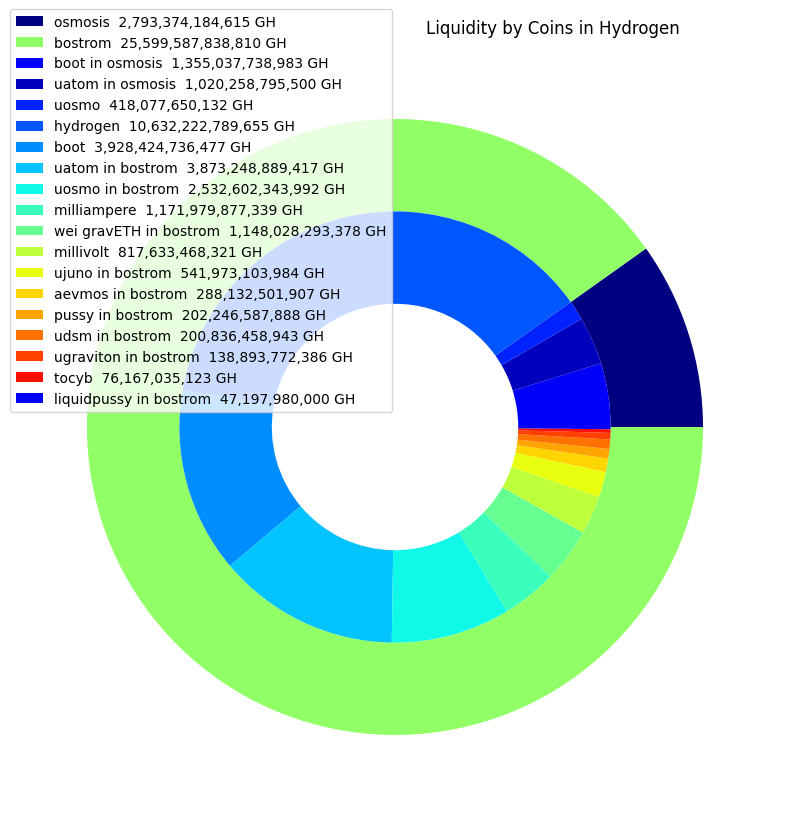

In [6]:
coin_list = set(chain(*pools_df.reserve_coin_denoms.to_list()))
coin_liquidity_data = []
print('Liquidity by Coins')
for coin in coin_list:
    pools_df.loc[:, f'{coin}_balance'] = pools_df.balances.map(lambda x: get_pool_value_by_coin(pool_balances=x, coin=coin))
    coin_liquidity_data.append({
        'coin': coin,
        'network': 'osmosis' if coin == 'uosmo' or coin[-7:] == 'osmosis' else 'bostrom',
        'liquidity': pools_df[f"{coin}_balance"].sum(),
        'liquidity, GH': pools_df[f"{coin}_balance"].sum() * price_enriched_df.loc['hydrogen', coin]})
coin_liquidity_df = pd.DataFrame(coin_liquidity_data).sort_values('liquidity, GH', ascending=False).reset_index().drop(columns=['index'])
display(HTML(
    coin_liquidity_df.to_html(
                index=False, notebook=True, show_dimensions=False)))

fig, ax = plt.subplots(figsize=(10, 10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cout = cm(np.arange(2) * 10)

outer = coin_liquidity_df.groupby('network')[
    'liquidity, GH'].sum().sort_values(ascending=True)
inner = coin_liquidity_df[coin_liquidity_df['liquidity, GH'] > 1].groupby(
    ['network', 'coin'])['liquidity, GH'].sum().sort_values(ascending=False).sort_index(axis=0, level=[0],
                                                                                             ascending=[False],
                                                                                             inplace=False)
inner_labels = ['{1}  {2:>,.0f} GH'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GH'.format(i, j) for i, j in zip(outer.index, outer)]
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
cin = cm(np.array([2, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17]))
ax.pie(inner.values.flatten(), radius=1 - size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set_title('Liquidity by Coins in Hydrogen                   ', loc='right')

plt.legend(outer_labels + inner_labels, loc=(0, 0.52))
handles, labels = ax.get_legend_handles_labels()
plt.show()

coin_liquidity_df.to_csv('data/coins_liquidity.csv')